npv: 5942.803085799824  nrm: 5942.803085799823
Iteration 0: alpha=0.07865 rad, de=-0.00919 rad, throttle=0.24982, residual=5942.803086
npv: 1774.0343642996515  nrm: 1774.0343642996515
Iteration 1: alpha=0.08725 rad, de=-0.00595 rad, throttle=0.18005, residual=1774.034364
npv: 531.4341071945666  nrm: 531.4341071945665
Iteration 2: alpha=0.08983 rad, de=-0.00497 rad, throttle=0.15959, residual=531.434107
npv: 159.36083650851992  nrm: 159.36083650851992
Iteration 3: alpha=0.09060 rad, de=-0.00468 rad, throttle=0.15350, residual=159.360837
npv: 47.80202298207837  nrm: 47.80202298207837
Iteration 4: alpha=0.09083 rad, de=-0.00459 rad, throttle=0.15167, residual=47.802023
npv: 14.340048392386349  nrm: 14.340048392386349
Iteration 5: alpha=0.09090 rad, de=-0.00457 rad, throttle=0.15112, residual=14.340048
npv: 4.3019647686193245  nrm: 4.3019647686193245
Iteration 6: alpha=0.09093 rad, de=-0.00456 rad, throttle=0.15096, residual=4.301965
npv: 1.2905851055849076  nrm: 1.2905851055849076
Iterati

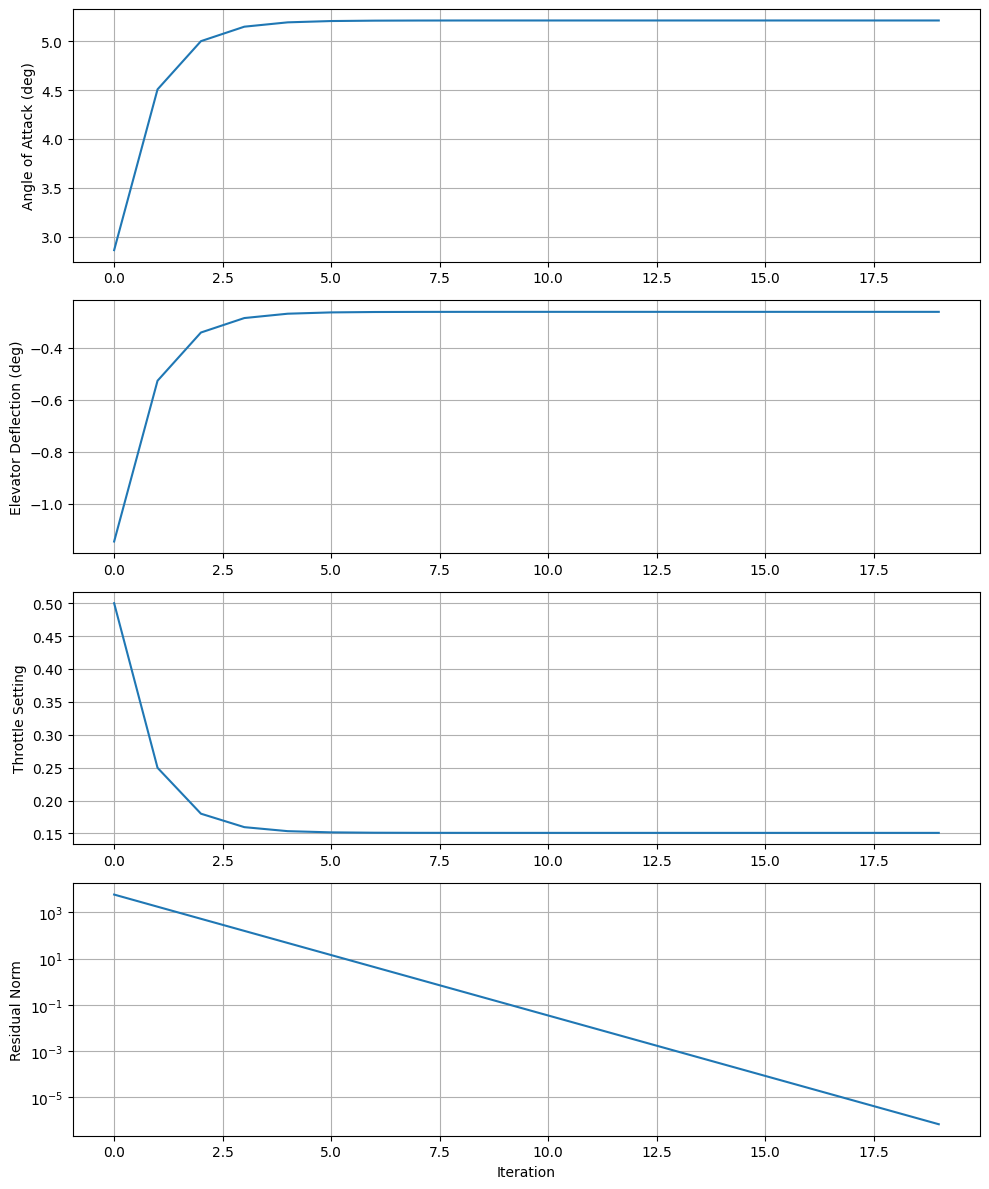


Testing trim at different velocities:

Trimming at 40 m/s:
npv: 8293.362056994738  nrm: 8293.362056994738
Iteration 0: alpha=0.12011 rad, de=-0.02646 rad, throttle=0.22287, residual=8293.362057
npv: 2463.188057947574  nrm: 2463.188057947574
Iteration 1: alpha=0.14114 rad, de=-0.02840 rad, throttle=0.15889, residual=2463.188058
npv: 736.8870041835236  nrm: 736.8870041835236
Iteration 2: alpha=0.14745 rad, de=-0.02898 rad, throttle=0.14141, residual=736.887004
npv: 220.8843711964061  nrm: 220.8843711964061
Iteration 3: alpha=0.14934 rad, de=-0.02916 rad, throttle=0.13633, residual=220.884371
npv: 66.24908350574832  nrm: 66.24908350574832
Iteration 4: alpha=0.14991 rad, de=-0.02921 rad, throttle=0.13481, residual=66.249084
npv: 19.873269633230752  nrm: 19.873269633230752
Iteration 5: alpha=0.15008 rad, de=-0.02922 rad, throttle=0.13436, residual=19.873270
npv: 5.961850529746949  nrm: 5.961850529746949
Iteration 6: alpha=0.15013 rad, de=-0.02923 rad, throttle=0.13423, residual=5.961851
np

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
#from scipy.optimize import newton

class AircraftModel:
    """A simplified aircraft model for trim analysis."""
    
    def __init__(self, mass=1000.0, S=16.0, c=1.5, CL_alpha=5.0, CD0=0.025, 
                 k=0.045, CM0=0.04, CM_alpha=-0.5, CM_de=-1.2):
        """
        Initialize aircraft parameters.
        
        Parameters:
        -----------
        mass : float
            Aircraft mass in kg
        S : float
            Wing area in m^2
        c : float
            Mean aerodynamic chord in m
        CL_alpha : float
            Lift curve slope per radian
        CD0 : float
            Zero-lift drag coefficient
        k : float
            Induced drag factor
        CM0 : float
            Zero-alpha pitch moment coefficient
        CM_alpha : float
            Pitch moment coefficient with respect to angle of attack
        CM_de : float
            Pitch moment coefficient with respect to elevator deflection
        """
        self.mass = mass
        self.S = S
        self.c = c
        self.CL_alpha = CL_alpha
        self.CD0 = CD0
        self.k = k
        self.CM0 = CM0
        self.CM_alpha = CM_alpha
        self.CM_de = CM_de
        self.g = 9.81  # gravity in m/s^2
        
    def CL(self, alpha):
        """Calculate lift coefficient at given angle of attack."""
        return self.CL_alpha * alpha
    
    def CD(self, alpha):
        """Calculate drag coefficient at given angle of attack."""
        return self.CD0 + self.k * self.CL(alpha)**2
    
    def CM(self, alpha, de):
        """Calculate pitch moment coefficient at given alpha and elevator."""
        return self.CM0 + self.CM_alpha * alpha + self.CM_de * de
    
    def compute_forces(self, alpha, de, velocity):
        """
        Compute forces and moments for given flight conditions.
        
        Parameters:
        -----------
        alpha : float
            Angle of attack in radians
        de : float
            Elevator deflection in radians
        velocity : float
            Airspeed in m/s
            
        Returns:
        --------
        tuple
            (Lift force, Drag force, Pitch moment)
        """
        q = 0.5 * 1.225 * velocity**2  # dynamic pressure using standard air density
        L = q * self.S * self.CL(alpha)
        D = q * self.S * self.CD(alpha)
        M = q * self.S * self.c * self.CM(alpha, de)
        return L, D, M
    
    def trim_equations(self, x, target_altitude=1000, target_velocity=100):
        """
        Function to find roots of to determine trim conditions.
        
        Parameters:
        -----------
        x : array-like
            [alpha, de, throttle] - Angle of attack, elevator deflection, throttle setting
        target_altitude : float
            Target altitude in meters (affects air density)
        target_velocity : float
            Target velocity in m/s
            
        Returns:
        --------
        array
            Residuals of trim equations that should be zero when trimmed
        """
        alpha, de, throttle = x
        
        # Compute forces
        L, D, M = self.compute_forces(alpha, de, target_velocity)
        
        # Weight
        W = self.mass * self.g
        
        # Thrust (simplified model: throttle directly controls thrust)
        T_max = W * 0.5  # Maximum thrust as a fraction of weight
        T = throttle * T_max
        
        # Trim equations (residuals should be zero)
        # 1. Vertical force balance: Lift = Weight
        eq1 = L - W
        
        # 2. Horizontal force balance: Thrust = Drag
        eq2 = T - D
        
        # 3. Pitch moment equilibrium: Moment = 0
        eq3 = M
        
        return np.array([eq1, eq2, eq3])

def trim_aircraft_newton_raphson(aircraft_model, target_velocity=100, initial_guess=None, max_iterations=50, tolerance=1e-6):
    """
    Find trim conditions using Newton-Raphson method.
    
    Parameters:
    -----------
    aircraft_model : AircraftModel
        The aircraft model to trim
    target_velocity : float
        Target airspeed in m/s
    initial_guess : array-like or None
        Initial guess for [alpha, de, throttle]
    max_iterations : int
        Maximum number of iterations
    tolerance : float
        Convergence tolerance
        
    Returns:
    --------
    dict
        Dictionary containing trim solution and iteration information
    """
    # Default initial guess if none provided
    if initial_guess is None:
        # [alpha (rad), elevator (rad), throttle (0-1)]
        initial_guess = np.array([0.05, 0.0, 0.5])
    
    # Current state
    x = initial_guess.copy()
    
    # History for debugging and visualization
    history = {
        'iterations': [],
        'alpha': [],
        'elevator': [],
        'throttle': [],
        'residuals': []
    }
    
    # Newton-Raphson iteration
    for i in range(max_iterations):
        # Compute residuals (trim equations)
        F = aircraft_model.trim_equations(x, target_velocity=target_velocity)
        
        # Record history
        history['iterations'].append(i)
        history['alpha'].append(x[0])
        history['elevator'].append(x[1])
        history['throttle'].append(x[2])
        history['residuals'].append(np.linalg.norm(F))
        
        npv = np.linalg.norm(F)
        nrm = math.sqrt(F[0]*F[0] + F[1]*F[1] + F[2]*F[2])
        
        print("npv:", npv, " nrm:", nrm)
        
        # Check convergence
        if np.linalg.norm(F) < tolerance:
            print(f"Converged after {i} iterations")
            break
        
        # Compute Jacobian matrix using finite differences
        J = np.zeros((3, 3))
        h = 1e-6  # Step size for finite difference
        
        for j in range(3):
            x_plus = x.copy()
            x_plus[j] += h
            F_plus = aircraft_model.trim_equations(x_plus, target_velocity=target_velocity)
            J[:, j] = (F_plus - F) / h
        
        # Solve for the update step
        try:
            dx = np.linalg.solve(J, -F)
        except np.linalg.LinAlgError:
            # Singular matrix, use pseudo-inverse
            dx = -np.linalg.pinv(J) @ F
        
        # Damping factor to prevent overshooting
        damping = 0.7
        
        # Update the state
        x = x + damping * dx
        
        # Constrain throttle to [0, 1]
        x[2] = np.clip(x[2], 0.0, 1.0)
        
        print(f"Iteration {i}: alpha={x[0]:.5f} rad, de={x[1]:.5f} rad, throttle={x[2]:.5f}, residual={np.linalg.norm(F):.6f}")
        
    else:
        print(f"Did not converge after {max_iterations} iterations")
    
    # Compute final forces and moments
    L, D, M = aircraft_model.compute_forces(x[0], x[1], target_velocity)
    
    # Create result dictionary
    result = {
        'converged': np.linalg.norm(F) < tolerance,
        'iterations': i+1,
        'alpha_rad': x[0],
        'alpha_deg': np.degrees(x[0]),
        'elevator_rad': x[1],
        'elevator_deg': np.degrees(x[1]),
        'throttle': x[2],
        'lift': L,
        'drag': D,
        'moment': M,
        'history': history
    }
    
    return result

def visualize_trim_results(result):
    """
    Visualize the trim solution convergence.
    
    Parameters:
    -----------
    result : dict
        Result dictionary from trim_aircraft function
    """
    history = result['history']
    
    fig, axs = plt.subplots(4, 1, figsize=(10, 12))
    
    # Plot angle of attack
    axs[0].plot(history['iterations'], np.degrees(history['alpha']))
    axs[0].set_ylabel('Angle of Attack (deg)')
    axs[0].grid(True)
    
    # Plot elevator deflection
    axs[1].plot(history['iterations'], np.degrees(history['elevator']))
    axs[1].set_ylabel('Elevator Deflection (deg)')
    axs[1].grid(True)
    
    # Plot throttle
    axs[2].plot(history['iterations'], history['throttle'])
    axs[2].set_ylabel('Throttle Setting')
    axs[2].grid(True)
    
    # Plot residual norm
    axs[3].semilogy(history['iterations'], history['residuals'])
    axs[3].set_ylabel('Residual Norm')
    axs[3].set_xlabel('Iteration')
    axs[3].grid(True)
    
    plt.tight_layout()
    plt.show()
    
def main():
    # Create aircraft model with realistic parameters
    # These parameters approximate a small general aviation aircraft
    aircraft = AircraftModel(
        mass=1200.0,      # kg
        S=16.0,           # m^2
        c=1.5,            # m
        CL_alpha=5.0,     # per radian
        CD0=0.025,
        k=0.045,
        CM0=0.04,
        CM_alpha=-0.5,    # per radian
        CM_de=-1.2        # per radian
    )
    
    # Target airspeed in m/s (approximately 100 knots)
    target_velocity = 51.4
    
    # Initial guess [alpha (rad), elevator (rad), throttle (0-1)]
    initial_guess = np.array([0.05, -0.02, 0.5])
    
    # Find trim solution
    trim_result = trim_aircraft_newton_raphson(
        aircraft,
        target_velocity=target_velocity,
        initial_guess=initial_guess
    )
    
    # Display results
    print("\nTrim Solution:")
    print(f"Angle of Attack: {trim_result['alpha_deg']:.3f} degrees")
    print(f"Elevator Deflection: {trim_result['elevator_deg']:.3f} degrees")
    print(f"Throttle Setting: {trim_result['throttle']:.3f}")
    print(f"Lift: {trim_result['lift']:.1f} N")
    print(f"Drag: {trim_result['drag']:.1f} N")
    print(f"Pitch Moment: {trim_result['moment']:.1f} N·m")
    
    # Visualize convergence
    visualize_trim_results(trim_result)
    
    # Try different flight conditions
    print("\nTesting trim at different velocities:")
    velocities = [40, 60, 80, 100]  # m/s
    
    for vel in velocities:
        print(f"\nTrimming at {vel} m/s:")
        trim_result = trim_aircraft_newton_raphson(
            aircraft,
            target_velocity=vel,
            initial_guess=initial_guess
        )
        print(f"Alpha: {trim_result['alpha_deg']:.3f} deg, "
              f"Elevator: {trim_result['elevator_deg']:.3f} deg, "
              f"Throttle: {trim_result['throttle']:.3f}")

if __name__ == "__main__":
    main()